# **Homework 5: Poisson matrix factorization** 
STAT 348, UChicago, Spring 2025

----------------
**Your name here:**

**Hours spent:**

(Please let us know how many hours in total you spent on this assignment so we can calibrate for future assignments. Your feedback is always welcome!)

----------------

<a href="https://colab.research.google.com/github/aschein/stat_348_2025/blob/main/assignments/hw5/hw5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

## Instructions

This homework focuses on themes in lectures 10-12 on coordinate ascent variational inference (CAVI), admixture models, and Poisson matrix factorization.

For reference, this homework is a close adaption of [HW5 for Scott Linderman's STATS 305C](https://github.com/slinderman/stats305c/blob/spring2023/assignments/hw5/hw5.ipynb).

Assignment is due **Wednesday May 14, 11:59pm** on GradeScope.


## Background

**Poisson matrix factorization** (PMF) is a mixed membership model like LDA, and it has close ties to non-negative factorization of count matrices. Let $\mathbf{X} \in \mathbb{N}^{N \times M}$ denote a count matrix with entries $x_{n,m}$. We model each entry as a Poisson random variable,

$$
\begin{align*}
x_{n,m} &\sim \mathrm{Po}\Big(\boldsymbol{\theta}_{n}^\top \boldsymbol{\phi}_{m} \Big)
= \mathrm{Po}\Big(\sum_{k=1}^K \theta_{n,k} \phi_{m,k} \Big),
\end{align*}
$$

where $\boldsymbol{\theta}_{n} \in \mathbb{R}_+^K$ and $\boldsymbol{\phi}_{m} \in \mathbb{R}_+^K$ are _non-negative_ feature vectors for row $n$ and column $m$, respectively. 

PMF has been used for recommender systems, aka collaborative filtering. In a recommender system, the rows correspond to users, the columns to items, and the entries $x_{n,m}$ to how much user $n$ liked item $m$ (on a scale of $0,1,2,\ldots$ stars, for example). The $K$ feature dimensions capture different aspects of items that users may weight in their ratings.

Note that the Poisson rate must be non-negative. It is sufficient to ensure $\boldsymbol{\theta}_{n}$ and $\boldsymbol{\phi}_{m}$ are non-negative. To that end, PMF uses gamma priors,

$$
\begin{align*}
\theta_{n,k} &\sim \mathrm{Ga}(\alpha_\theta, \beta_\theta) \\
\phi_{m,k} &\sim \mathrm{Ga}(\alpha_\phi, \beta_\phi),
\end{align*}
$$

where $\alpha_\star$ and $\beta_\star$ are hyperparameters. When $\alpha_\star < 1$, the gamma distribution has a sharp peak at zero and the prior induces sparsity in the feature vectors.

### Latent variable formulation

PMF can be rewritten in terms of a latent variable model. Note that,

$$
\begin{align*}
x_{n,m} \sim \mathrm{Po}\Big(\sum_{k=1}^K \theta_{n,k} \phi_{m,k} \Big)
\iff x_{n,m} &= \sum_{k=1}^K z_{n,m,k} \\
z_{n,m,k} &\sim \mathrm{Po}(\theta_{nk} \phi_{mk}) \quad \text{independently}.
\end{align*}
$$

From this perspective, a user's rating of an item is a sum of ratings along each feature dimension, and each feature rating is an independent Poisson random variable. 

The joint distribution is,

$$
\begin{align*}
p(\mathbf{X}, \mathbf{Z}, \boldsymbol{\Theta}, \boldsymbol{\Phi}) 
&= 
\left[\prod_{n=1}^N \prod_{m=1}^M \mathbb{I}\Big[x_{n,m}=\sum_{k=1}^K z_{n,m,k} \Big] 
\prod_{k=1}^K \mathrm{Po}(z_{n,m,k} \mid \theta_{n,k} \phi_{m,k}) 
\right] \\
&\qquad
\times \left[ \prod_{n=1}^N \prod_{k=1}^K \mathrm{Ga}(\theta_{n,k} \mid \alpha_\theta, \beta_\theta) \right]
\times \left[ \prod_{m=1}^M \prod_{k=1}^K \mathrm{Ga}(\phi_{m,k} \mid \alpha_\phi, \beta_\phi) \right]
\end{align*}
$$

where $\mathbf{Z} \in \mathbb{N}^{N\times M \times K}$ denotes the _tensor_ of feature ratings, $\boldsymbol{\Theta} \in \mathbb{R}_+^{N \times K}$ is a matrix with rows $\boldsymbol{\theta}_n$, and $\boldsymbol{\Phi} \in \mathbb{R}_+^{M \times K}$ is a matrix with rows $\boldsymbol{\phi}_m$. 

## Setup

In [1]:
import torch
from torch.distributions import Distribution, Gamma, Poisson, Multinomial
from torch.distributions.kl import kl_divergence

from tqdm.auto import trange

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("notebook")

d:\anaconda\envs\Pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Problem 1: Conditional distributions [math]

Since this model is constructed from conjugate exponential family distributions, the conditionals are available in closed form. We will let $\mathbf{z}_{n,m} = (z_{n,m,1}, \ldots, z_{n,m,K})$.


### Problem 1a: Derive the conditional for $\mathbf{z}_{n, m}$

Find the conditional density $p(\mathbf{z}_{n,m} \mid x_{n,m}, \boldsymbol{\theta}_{n}, \boldsymbol{\phi}_{m})$. 



---

*Your answer here.*
$$
\begin{align*}
p(z_{n,m}|x_{n,m},\theta_n,\phi_m) &\propto p(x_{n,m}|z_{n,m},\theta_n,\phi_m)\cdot p(z_{n,m}|\theta_n,\phi_m)\\
&\propto 1(x_{n,m}=\sum_{k=1}^K z_{n,m,k})\prod_{k=1}^K Pois(z_{n,m,k}|\theta_{n,m},\phi_{m,k})\\
&\propto 1(x_{n,m}=\sum_{k=1}^K z_{n,m,k})\prod_{k=1}^K \frac{(\theta_{n,k}\phi_{m,k})^{z_{n,m,k}}e^{-\theta_{n,k}\phi_{m,k}}}{z_{n,m,k}!}
\end{align*}
$$
Denote $\pi_{n,m,k}=\frac{\theta_{n,k}\phi_{m,k}}{\sum_{k=1}^K\theta_{n,k}\phi_{m,k}}$
$$
\begin{align*}
p(z_{n,m}|x_{n,m},\theta_n,\phi_m) &= Multinomial(z_{n,m};x_{n,m},\pi_{n,m})\\
&= 1(x_{n,m}=\sum_{k=1}^K z_{n,m,k}) \frac{x_{n,m}!}{\prod_{k=1}^K z_{n,m,k}}\prod_{k=1}^K \pi_{n,m,k}^{z_{n,m,k}}
\end{align*}
$$

---

### Problem 1b: Derive the conditional for $\theta_{n,k}$

Find the conditional density $p(\theta_{n,k} \mid \mathbf{Z}, \boldsymbol{\Phi})$.


---

*Your answer here.*
$$
\begin{align*}
p(\theta_{n,k}|Z,\Phi) &\propto p(z_{n,1:M,k}|\theta_{n,k},\Phi)\cdot p(\theta_{n,k})\\
&\propto \prod_{m=1}^M p(z_{n,m,k}|\theta_{n,k},\phi_{m,k}) \cdot p(\theta_{n,k}) \\
&\propto \prod_{m=1}^M \frac{(\theta_{n,k}\phi_{m,k})^{z_{n,m,k}}e^{-\theta_{n,k}\phi_{m,k}}}{z_{n,m,k}!} \cdot \theta_{n,k}^{\alpha_{\theta}-1}e^{-\beta_{\theta}\theta_{n,k}}\\
&\propto \theta_{n,k}^{\sum_{m=1}^M z_{n,m,k}+\alpha_{\theta}-1}e^{-(\sum_{m=1}^M \phi_{m,k}+\beta_{\theta})\theta_{n,k}}\\
&\propto Gamma(\sum_{m=1}^M z_{n,m,k}+\alpha_{\theta}, \sum_{m=1}^M \phi_{m,k}+\beta_{\theta})\\
\end{align*}
$$
Denote $\alpha_m = \sum_{m=1}^M z_{n,m,k}+\alpha_{\theta}, \beta_m = \sum_{m=1}^M \phi_{m,k}+\beta_{\theta}$
$$
\begin{align*}
p(\theta_{n,k}|Z,\Phi) &= \frac{\beta_m^{\alpha_m}}{\Gamma(\alpha_m)}\theta_{n,k}^{\alpha_m-1}e^{-\beta_m \theta_{n,k}}
\end{align*}
$$
---

### Problem 1c: Derive the conditional for $\phi_{m, k}$

Find the conditional density $p(\phi_{m, k} \mid \mathbf{Z}, \mathbf{\Theta})$.

---
*Your answer here.*

$$
\begin{align*}
p(\phi_{m,k}|Z,\Phi) &\propto p(z_{1:N,m,k}|\phi_{m,k},\Theta)\cdot p(\phi_{m,k})\\
&\propto \prod_{n=1}^N p(z_{n,m,k}|\theta_{n,k},\phi_{m,k}) \cdot p(\phi_{m,k}) \\
&\propto \prod_{n=1}^N \frac{(\theta_{n,k}\phi_{m,k})^{z_{n,m,k}}e^{-\theta_{n,k}\phi_{m,k}}}{z_{n,m,k}!} \cdot \phi_{m,k}^{\alpha_{\phi}-1}e^{-\beta_{\phi}\phi_{m,k}}\\
&\propto \phi_{m,k}^{\sum_{n=1}^N z_{n,m,k}+\alpha_{\phi}-1}e^{-(\sum_{n=1}^N \theta_{n,k}+\beta_{\theta})\phi_{m,k}}\\
&\propto Gamma(\sum_{n=1}^N z_{n,m,k}+\alpha_{\phi}, \sum_{n=1}^N \theta_{n,k}+\beta_{\phi})\\
\end{align*}
$$
Denote $\alpha_n = \sum_{n=1}^N z_{n,m,k}+\alpha_{\phi}, \beta_n = \sum_{n=1}^N \theta_{n,k}+\beta_{\phi}$
$$
\begin{align*}
p(\phi_{m,k}|Z,\Theta) &= \frac{\beta_n^{\alpha_n}}{\Gamma(\alpha_n)}\phi_{m,k}^{\alpha_n-1}e^{-\beta_n \phi_{m,k}}
\end{align*}
$$
---

## Problem 2: Coordinate ascent variational inference [math]

We will perform inference in this model using a mean-field variational posterior which factorizes according to:

$$
\begin{align*}
q(\mathbf{Z}, \boldsymbol{\Phi}, \boldsymbol{\Theta}) 
&= q(\mathbf{Z}) q(\boldsymbol{\Phi}) q(\boldsymbol{\Theta}) \\
&= \left[\prod_{n = 1}^N \prod_{m = 1}^M q(\mathbf{z}_{n, m}) \right] \left[\prod_{n = 1}^N \prod_{k = 1}^K q(\theta_{n, k}) \right] \left[ \prod_{m = 1}^M \prod_{k = 1}^K q(\phi_{m, k}) \right]
\end{align*}
$$

The optimal mean field factors will have the same forms as the conditional distributions above.


### Problem 2a: Derive the CAVI update for $q(\mathbf{z}_{n, m})$

Show that, fixing $q(\boldsymbol{\Phi})$ and $q(\boldsymbol{\Theta})$, the optimal $q(\mathbf{z}_{n, m})$ is given by:

$$
\begin{align*}
q(\mathbf{z}_{n,m}; \boldsymbol{\lambda}^{(z)}_{n,m}) 
&= \mathrm{Mult}(\mathbf{z}_{n,m}; x_{n,m}, \boldsymbol{\lambda}^{(z)}_{n,m}) \\
\log \lambda^{(z)}_{n,m,k} &= \mathbb{E}_q[\log \theta_{n,k} + \log \phi_{m,k}] + c
\end{align*}
$$

---

*Your answer here.*
$$
\begin{align*}
q(z_{n,m}) &\propto exp(E_{q\backslash_{ z_{n,m}}}[log p(z_{n,m}|\Theta,\Phi,X)])\\
&\propto 1(x_{n,m}=\sum_{k=1}^K z_{n,m,k}) exp(E_{q\backslash_{ z_{n,m}}}[\sum_{k=1}^K z_{n,m,k}log\pi_{n,m,k}-\sum_{k=1}^K logz_{n,m,k}])\\
&\propto 1(x_{n,m}=\sum_{k=1}^K z_{n,m,k}) exp(E_{q\backslash_{ z_{n,m}}}[\sum_{k=1}^K z_{n,m,k}(log\theta_{n,k}+log\phi_{m,k}-log\sum\theta_{n,k}\phi_{m,k})-\sum_{k=1}^K logz_{n,m,k}])\\
&\propto 1(x_{n,m}=\sum_{k=1}^K z_{n,m,k}) exp(\sum_{k=1}^K z_{n,m,k}log\lambda_{n,m,k}^{(z)}-\sum_{k=1}^K logz_{n,m,k})\\
&\propto Multinomial(z_{n,m};x_{n,m},\lambda_{n,m}^{(z)})
\end{align*}
$$
---

### Problem 2b: Derive the CAVI update for $q(\theta_{n, k})$

Show that, fixing $q(\mathbf{Z})$ and $q(\boldsymbol{\Phi})$, the optimal $q(\theta_{n, k})$ is given by:

$$
\begin{align*}
q(\theta_{n,k}; {\lambda}^{(\theta)}_{n,k,1}, {\lambda}^{(\theta)}_{n,k,2}) 
&= \mathrm{Ga}(\theta_{n,k}; {\lambda}^{(\theta)}_{n,k,1}, {\lambda}^{(\theta)}_{n,k,2}) \\
{\lambda}^{(\theta)}_{n,k,1} &=  \alpha_\theta + \sum_{m=1}^M \mathbb{E}_q[z_{n,m,k}] \\
{\lambda}^{(\theta)}_{n,k,2} &=  \beta_\theta + \sum_{m=1}^M \mathbb{E}_q[\phi_{m,k}] 
\end{align*}
$$

---

*Your answer here.*
$$
\begin{align*}
q(\theta_{n,k}) &= exp(E_{q\backslash_{\theta_{n,k}}}logp(\theta_{n,k}|Z,\Phi))\\
&\propto exp(E_{q\backslash_{\theta_{n,k}}}(\sum_{m=1}^Mz_{n,m,k}+\alpha_{\theta}-1)log\theta_{n,k}-(\sum_{m=1}^M\phi_{m,k}+\beta_{\theta})\theta_{n,k})\\
&\propto exp((\lambda_{n,k,1}^{(\theta)}-1)log\theta_{n,k}-\lambda_{n,k,2}^{(\theta)}\theta_{n,k})\\
&= Gamma(\theta_{n,k};\lambda_{n,k,1}^{(\theta)},\lambda_{n,k,2}^{(\theta)})
\end{align*}
$$

---

### Problem 2c: Derive the CAVI update for $q(\phi_{m, k})$
Show that, fixing $q(\mathbf{Z})$ and $q(\boldsymbol{\Theta})$, the optimal $q(\phi_{m, k})$ is given by:

$$
\begin{align*}
q(\phi_{m,k}; {\lambda}^{(\phi)}_{m,k,1}, {\lambda}^{(\phi)}_{m,k,2}) 
&= \mathrm{Ga}(\phi_{m,k}; {\lambda}^{(\phi)}_{m,k,1}, \lambda^{(\phi)}_{m,k,2}) \\
{\lambda}^{(\phi)}_{m,k,1} &=  \alpha_\phi + \sum_{n=1}^N \mathbb{E}_q[z_{n,m,k}] \\
{\lambda}^{(\phi)}_{m,k,2} &=  \beta_\phi + \sum_{n=1}^N \mathbb{E}_q[\theta_{n,k}] 
\end{align*}
$$

---

*Your answer here.*
$$
\begin{align*}
q(\phi_{m,k}) &= exp(E_{q\backslash_{\phi_{m,k}}}logp(\phi_{m,k}|Z,\Theta))\\
&\propto exp(E_{q\backslash_{\phi_{m,k}}}(\sum_{n=1}^Nz_{n,m,k}+\alpha_{\phi}-1)log\phi_{m,k}-(\sum_{n=1}^N\theta_{n,k}+\beta_{\phi})\phi_{m,k})\\
&\propto exp((\lambda_{m,k,1}^{(\phi)}-1)log\phi_{m,k}-\lambda_{m,k,2}^{(\phi)}\phi_{m,k})\\
&= Gamma(\phi_{m,k};\lambda_{m,k,1}^{(\phi)},\lambda_{m,k,2}^{(\phi)})
\end{align*}
$$
---

### Problem 2d: Find the expected sufficient statistics

To update the variational factors, we need the expectations $\mathbb{E}_q[z_{n, m, k}]$, $\mathbb{E}_q[\log \theta_{n,k} + \log \phi_{m,k}]$, $\mathbb{E}_q[\theta_{n, k}]$, and $\mathbb{E}_q[\phi_{m, k}]$. Assume that each factor follows the forms derived above. That is, assume $q(\mathbf{z}_{n, m})$ is multinomial with parameters $\lambda_{n, m}^{(z)}$ while $q(\theta_{n, k})$ and $q(\phi_{m k})$ are gamma with parameters $\left( \lambda_{n, k, 1}^{(\theta)}, \lambda_{n, k, 2}^{(\theta)} \right)$ and $\left( \lambda_{m, k, 1}^{(\phi)}, \lambda_{m, k, 2}^{(\phi)} \right)$, respectively. Derive what each of these expectations are in closed form.

---

*Your answer here.*
$$
\begin{align*}
E_q[z_{n,m,k}] &= x_{n,m}\lambda_{n,m,k}^{(z)}\\
E_q[log\theta_{n,k}]&=\psi(\lambda_{n,k,1}^{(\theta)})-log\lambda_{n,k,2}^{(\theta)}\\
E_q[log\phi{m,k}] &= \psi(\lambda_{m,k,1}^{(\phi)})-log\lambda_{m,k,2}^{(\phi)}\\
E_q[log\theta_{n,k}+log\phi{m,k}] &= \psi(\lambda_{n,k,1}^{(\theta)})-log\lambda_{n,k,2}^{(\theta)}+\psi(\lambda_{m,k,1}^{(\phi)})-log\lambda_{m,k,2}^{(\phi)}\\
E_q[\theta_{n,k}] &= \frac{\lambda_{n,k,1}^{(\theta)}}{\lambda_{n,k,2}^{(\theta)}}\\
E_q[\phi_{m,k}] &= \frac{\lambda_{m,k,1}^{(\phi)}}{\lambda_{m,k,2}^{(\phi)}}
\end{align*}
$$
Here $\psi(x)=\frac{d}{dx}log\Gamma(x)$ is the digamma function.

---

## Problem 3: Implement Coordinate Ascent Variational Inference [code]


First we'll give some helper functions and objects. Because PyTorch doesn't offer support for batched multinomial distributions in which the total counts differ (e.g. each $\mathbf{z}_{n, m}$ follows a multinomial distribution in which the total count is $x_{n, m}$), we have defined a `BatchedMultinomial` distribution for your convenience. This distribution doesn't support sampling, but will return the mean of each Multinomial variable in its batch. This is exactly what is needed for the CAVI updates.

In [2]:
def gamma_expected_log(gamma_distbn):
    """Helper function to compute the expectation of log(X) where X follows a 
    gamma distribution.
    """
    return torch.digamma(gamma_distbn.concentration) - torch.log(gamma_distbn.rate)

class BatchedMultinomial(Multinomial):
    """ 
    Creates a Multinomial distribution parameterized by `total_count` and
    either `probs` or `logits` (but not both). The innermost dimension of
    `probs` indexes over categories. All other dimensions index over batches.

    The `probs` argument must be non-negative, finite and have a non-zero sum,
    and it will be normalized to sum to 1 along the last dimension. `probs` will 
    return this normalized value. The `logits` argument will be interpreted as 
    unnormalized log probabilities and can therefore be any real number. It will
    likewise be normalized so that the resulting probabilities sum to 1 along
    the last dimension. `logits` will return this normalized value.

    Args:
        total_count (Tensor): number of trials
        probs (Tensor): event probabilities
            Has shape total_count.shape + (num_categories,)
        logits (Tensor): event log probabilities (unnormalized)
            Has shape total_count.shape + (num_categories,)

    Note: this text is mostly from the PyTorch documentation for the 
        Multinomial distribution
    """
    def __init__(self, total_count, probs=None, logits=None, validate_args=None):
        super().__init__(probs=probs, logits=logits, validate_args=validate_args)
        self.total_count = total_count

    @property
    def mean(self):
        return self.total_count[..., None] * self.probs


### Problem 3a: Implement a CAVI update step

Using the update equations derived in Problem 2, complete the `cavi_step` function below. 

*Hint:* Given a `Distribution` named `d`, `d.mean` returns the mean of that distribution.

In [3]:
def cavi_step(X, q_z, q_theta, q_phi, alpha_theta, beta_theta, alpha_phi, beta_phi):
    """One step of CAVI.

    Args:
        X: torch.tensor of shape (N, M)
        q_z: variational posterior over z, BatchedMultinomial distribution
        q_theta: variational posterior over theta, Gamma distribution
        q_phi: variational posterior over eta, Gamma distribution

    Returns:
        (q_z, q_theta, q_phi): Updated distributions after performing CAVI updates
    """
    ###
    # Your code here
    N, M = X.shape
    K = q_z.probs.shape[-1]

    # === E_q[log theta] and E_q[log phi] ===
    E_log_theta = gamma_expected_log(q_theta)  # (N, K)
    E_log_phi = gamma_expected_log(q_phi)      # (M, K)

    # === E_q[theta] and E_q[phi] ===
    E_theta = q_theta.mean                     # (N, K)
    E_phi = q_phi.mean                         # (M, K)

    # === Update q_z ===
    log_lambda_z = E_log_theta.unsqueeze(1) + E_log_phi.unsqueeze(0)  # (N, M, K)
    lambda_z = torch.softmax(log_lambda_z, dim=-1)                    # (N, M, K)
    q_z = BatchedMultinomial(total_count=X, probs=lambda_z)

    # === E_q[z] ===
    E_z = q_z.mean  # (N, M, K) = X[n,m] * lambda_z[n,m,k]

    # === Update q_theta ===
    lambda_theta_1 = alpha_theta + E_z.sum(dim=1)                     # (N, K)
    lambda_theta_2 = beta_theta + E_phi.sum(dim=0).unsqueeze(0)      # (N, K)
    q_theta = Gamma(concentration=lambda_theta_1, rate=lambda_theta_2)

    # === Update q_phi ===
    lambda_phi_1 = alpha_phi + E_z.sum(dim=0)                         # (M, K)
    lambda_phi_2 = beta_phi + E_theta.sum(dim=0).unsqueeze(0)        # (M, K)
    q_phi = Gamma(concentration=lambda_phi_1, rate=lambda_phi_2)

    return q_z, q_theta, q_phi

### Problem 3b: ELBO Calculation [math]

Recall that the evidence lower bound is defined as:

$$
\mathcal{L}(q) = \mathbb{E}_q \left[ \log p(\mathbf{X}, \mathbf{Z}, \boldsymbol{\Phi}, \boldsymbol{\Theta}) - \log q(\mathbf{Z}, \boldsymbol{\Phi}, \boldsymbol{\Theta}) \right]
$$

Assume that $q(\mathbf{Z})$ has support contained in $\{\mathbf{Z}: \sum_{k=1}^K z_{n, m, k} = x_{n, m} \text{ for all } n, m\}$. Show that we can rewrite $\mathcal{L}(q)$ as:

$$
\mathcal{L}(q) = \mathbb{E}_q [\log p(\mathbf{Z} \mid \boldsymbol{\Theta}, \boldsymbol{\Phi}) - \log q(\mathbf{Z})]  - \mathrm{KL}(q(\boldsymbol{\Theta}) || p(\boldsymbol{\Theta})) - \mathrm{KL}(q(\boldsymbol{\Phi}) || p(\boldsymbol{\Phi}))
$$

Next, use that $q(\mathbf{z}_{n,m}; \boldsymbol{\lambda}^{(z)}_{n,m}) =  \mathrm{Mult}(\mathbf{z}_{n,m}; x_{n,m}, \boldsymbol{\lambda}^{(z)}_{n,m})$ and by plug in the densities of the Poisson and Multinomial distributions to show that we have:

$$
\begin{align*}
&\mathbb{E}_q [\log p(\mathbf{Z} \mid \boldsymbol{\Theta}, \boldsymbol{\Phi}) - \log q(\mathbf{Z})] 
= \\
&\qquad \sum_{n = 1}^N \sum_{m = 1}^M \mathbb{E}_q \left[ \sum_{k =1}^K - \theta_{n, k} \phi_{m, k}  + z_{n, m, k} \log( \theta_{n, k} \phi_{m, k} ) - z_{n,m, k} \log(\lambda_{n, m, k}^{(z)}) \right] - \log(x_{n, m}!)
\end{align*}
$$

Explain why we have:

$$
\begin{align*}
&\mathbb{E}_q \left[ - \theta_{n, k} \phi_{m, k}  + z_{n, m, k} \log( \theta_{n, k} \phi_{m, k} ) - z_{n,m, k} \log(\lambda_{n, m, k}^{(z)}) \right] = \\
&\qquad - \mathbb{E}_q \left[\theta_{n, k}\right] \mathbb{E}_q \left[\phi_{m, k}\right]  + \mathbb{E}_q \left[z_{n, m, k} \right] \left( \mathbb{E}_q \left[\log( \theta_{n, k}) \right] + \mathbb{E}_q \left[\log (\phi_{m, k} )\right] - \log(\lambda_{n, m, k}^{(z)}) \right)  
\end{align*}
$$

---

*Your answer here.*

1.
$$
\begin{align*}
L(q) &= E_q[log p(Z,\Phi,\Theta)-log q(Z,\Phi,\Theta)]\\
&= E_q[log(p(Z|\Phi,\Theta)p(\Phi)p(\Theta))-log(q(Z)q(\Phi)q(\Theta))]\\
&= E_q[logp(Z|\Phi,\Theta)-logq(Z)+logp(\Phi)-logq(\Phi)+logp(\Theta)-logq(\Theta)]\\
&= E_q[logp(Z|\Phi,\Theta)-logq(Z)-KL(q(\Theta)||p(\Theta))-KL(q(\Phi)||p(\Phi))]
\end{align*}
$$
2.
$$
\begin{align*}
logp(z_{n,m,k}|\theta_{n,k},\phi_{m,k})&=-\theta_{n,k}\phi_{m,k}+z_{n,m,k}log(\theta_{n,k}\phi_{m,k})-logz_{n,m,k}!\\
log q(z_{n,m})&=logx_{n,m}!-\sum_{k=1}^Klogz_{n,m,k}!+\sum_{k=1}^Kz_{n,m,k}log\lambda_{n,m,k}^{(z)}\\
E_q[logp(Z|\Phi,\Theta)-logq(Z)]&=\sum_{n=1}^N \sum_{m=1}^M E_q[\sum_{k=1}^K(-\theta_{n,k}\phi_{m,k}+z_{n,m,k}log(\theta_{n,k}\phi_{m,k})-logz_{n,m,k}!)-(logx_{n,m}!-\sum_{k=1}^Klogz_{n,m,k}!+\sum_{k=1}^Kz_{n,m,k}log\lambda_{n,m,k}^{(z)})]\\
&=\sum_{n=1}^N \sum_{m=1}^M E_q[\sum_{k=1}^K(-\theta_{n,k}\phi_{m,k}+z_{n,m,k}log(\theta_{n,k}\phi_{m,k})-z_{n,m,k}log\lambda_{n,m,k}^{(z)})]-log(x_{n,m})!
\end{align*}
$$
3.
Since $z_{n,m,k}$, $\theta_{n,k}$ and $\phi_{m,k}$ are independent under q, $\lambda_{n,m,k}^{(z)}$ is a constant, we have following equations:
$$
\begin{align*}
E_q[\theta_{n,k}\phi_{m,k}]&=E_q[\theta_{n,k}]E_q[\phi_{m,k}]\\
E_q[z_{n,m,k}log\theta_{n,k}] &= E_q[z_{n,m,k}]E_q[log\theta_{n,k}]\\
E_q[z_{n,m,k}log\phi_{m,k}] &= E_q[z_{n,m,k}]E_q[log\phi_{m,k}]\\
E_q[z_{n,m,k}log\lambda_{n,m,k}^{(z)}] &= E_q[z_{n,m,k}]E_q[log\lambda_{n,m,k}^{(z)}]\\
\end{align*}
$$
Therefore, we have
$$
\begin{align*}
&\mathbb{E}_q \left[ - \theta_{n, k} \phi_{m, k}  + z_{n, m, k} \log( \theta_{n, k} \phi_{m, k} ) - z_{n,m, k} \log(\lambda_{n, m, k}^{(z)}) \right] = \\
&\qquad - \mathbb{E}_q \left[\theta_{n, k}\right] \mathbb{E}_q \left[\phi_{m, k}\right]  + \mathbb{E}_q \left[z_{n, m, k} \right] \left( \mathbb{E}_q \left[\log( \theta_{n, k}) \right] + \mathbb{E}_q \left[\log (\phi_{m, k} )\right] - \log(\lambda_{n, m, k}^{(z)}) \right)  
\end{align*}
$$

---

### Problem 3c: Implement the ELBO [code]

Using our expression above, write a function which evaluates the evidence lower bound.

*Hints:*
- Use the `kl_divergence` function imported above to compute the KL divergence between two `Distributions` in the same family.
- Recall that for integers $n$, $\Gamma(n + 1) = n!$ where $\Gamma$ is the [Gamma function](https://en.wikipedia.org/wiki/Gamma_function). $\log \Gamma$ is implemented in PyTorch as `torch.lgamma`.

In [4]:
def elbo(X, q_z, q_theta, q_phi, p_theta, p_phi):
    """Compute the evidence lower bound.
    
    Args:
        X: torch.tensor of shape (N, M)
        q_z: variational posterior over z, BatchedMultinomial distribution
        q_theta: variational posterior over theta, Gamma distribution
        q_phi: variational posterior over eta, Gamma distribution
        p_theta: prior over theta, Gamma distribution
        p_phi: prior over eta, Gamma distribution

    Returns:
        elbo: torch.tensor of shape [] 
    """
    ###
    # Your code below
    N, M = X.shape
    K = q_z.probs.shape[-1]

    # Expected latent counts
    lambda_z = q_z.probs  # shape (N, M, K)
    E_z = lambda_z * X.unsqueeze(-1)  # shape (N, M, K)

    # Expectations of theta and phi
    E_theta = q_theta.mean  # (N, K)
    E_phi = q_phi.mean      # (M, K)
    E_log_theta = q_theta.concentration.digamma() - q_theta.rate.log()  # (N, K)
    E_log_phi = q_phi.concentration.digamma() - q_phi.rate.log()        # (M, K)

    # Compute expected log p(z | theta, phi) - log q(z)
    E_theta_phi = E_theta.unsqueeze(1) * E_phi.unsqueeze(0)  # shape (N, M, K)
    E_log_theta_phi = E_log_theta.unsqueeze(1) + E_log_phi.unsqueeze(0)  # shape (N, M, K)
    log_lambda = lambda_z.log()  # shape (N, M, K)

    term1 = -E_theta_phi + E_z * (E_log_theta_phi - log_lambda)  # shape (N, M, K)
    term1_sum = term1.sum() - torch.lgamma(X + 1).sum()  # scalar

    # KL divergences
    kl_theta = kl_divergence(q_theta, p_theta).sum()
    kl_phi = kl_divergence(q_phi, p_phi).sum()

    elbo = term1_sum - kl_theta - kl_phi
    return elbo / torch.sum(X)

### Implement CAVI loop [given]

Using your functions defined above, complete the function `cavi` below. `cavi` loops for some number of iterations, updating each of the variational factors in sequence and evaluating the ELBO at each step.

In [5]:
from torch.distributions import Uniform

def cavi(data, 
         num_factors=10, 
         num_iters=100, 
         tol=1e-5, 
         alpha_theta=0.1,
         beta_theta=1.0,
         alpha_phi=0.1,
         beta_phi=1.0,
         seed=0
        ):
    """Run coordinate ascent VI for Poisson matrix factorization.

    Args:

    Returns:
        elbos, (q_z, q_theta, q_phi):
    """
    data = data.float()
    N, M = data.shape
    K = num_factors      # short hand
    
    # Initialize the variational posteriors.
    q_phi = Gamma(Uniform(0.5 * alpha_phi, 1.5 * alpha_phi).sample((M, K)),
                  Uniform(0.5 * beta_phi, 1.5 * beta_phi).sample((M, K)))
    q_theta = Gamma(Uniform(0.5 * alpha_theta, 1.5 * alpha_theta).sample((N, K)),
                    Uniform(0.5 * beta_theta, 1.5 * beta_theta).sample((N, K)))
    q_z = BatchedMultinomial(data, logits=torch.zeros((N, M, K)))

    p_theta = Gamma(alpha_theta, beta_theta)
    p_phi = Gamma(alpha_phi, beta_phi)
    
    # Run CAVI
    elbos = [elbo(data, q_z, q_theta, q_phi, p_theta, p_phi)]
    for itr in trange(num_iters):
        q_z, q_theta, q_phi = cavi_step(data, q_z, q_theta, q_phi,
                                        alpha_theta, beta_theta,
                                        alpha_phi, beta_phi)
        
        elbos.append(elbo(data, q_z, q_theta, q_phi, p_theta, p_phi))
    return torch.tensor(elbos), (q_z, q_theta, q_phi)
        

### Test your implementation on a toy dataset

To check your implementation is working properly, we will fit a mean-field variational posterior using data sampled from the true model. 

torch.Size([100, 1000])
Max data:   tensor(14.)
num zeros:  tensor(95568)


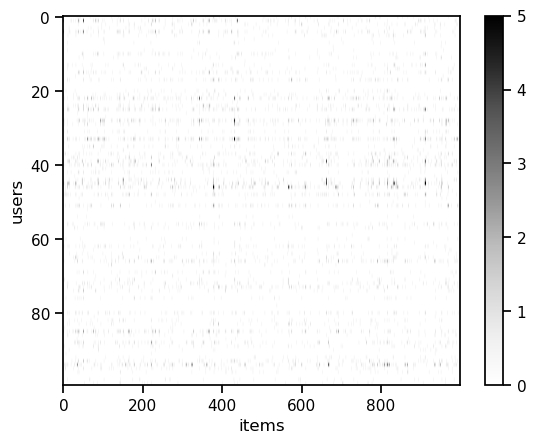

In [6]:
# Constants
N = 100   # num "users"
M = 1000 # num "items"
K = 5     # number of latent factors

# Hyperparameters
alpha = 0.1  # sparse gamma prior with mean alpha/beta 
beta = 1.0

# Sample data from the model
torch.manual_seed(305)
theta = Gamma(alpha, beta).sample(sample_shape=(N, K))
phi = Gamma(alpha, beta).sample(sample_shape=(M, K))
data = Poisson(theta @ phi.T).sample()

print(data.shape)
# Plot the data matrix
plt.imshow(data, aspect="auto", vmax=5, cmap="Greys")
plt.xlabel("items")
plt.ylabel("users")
plt.colorbar()

print("Max data:  ", data.max())
print("num zeros: ", torch.sum(data == 0))

In [9]:
elbos, (q_z, q_theta, q_phi) = cavi(data)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [02:25<00:00,  1.45s/it]


Text(0, 0.5, 'ELBO per entry')

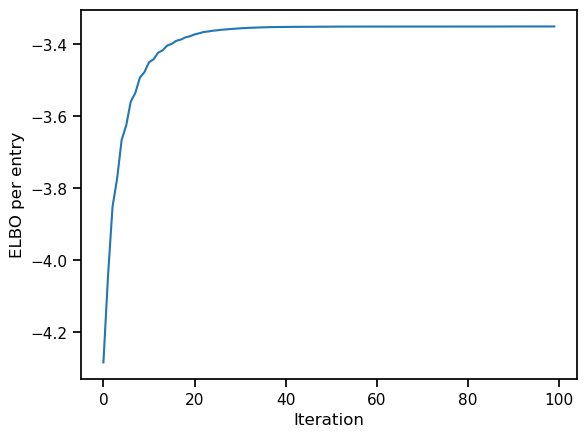

In [10]:
plt.plot(elbos[1:])
plt.xlabel("Iteration")
plt.ylabel("ELBO per entry")

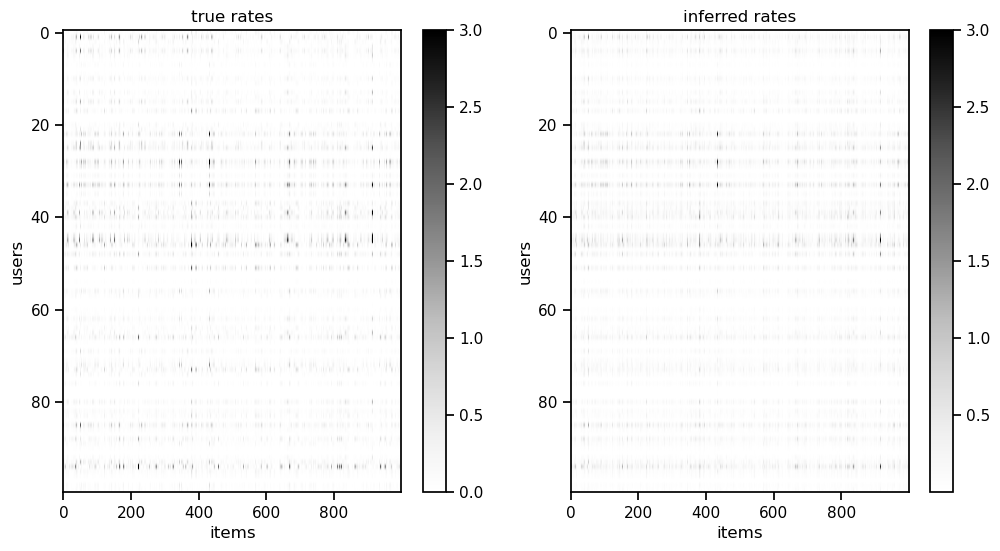

In [11]:
true_rates = theta @ phi.T
inf_rates = q_theta.mean @ q_phi.mean.T

# Plot the data matrix
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(true_rates, aspect="auto", vmax=3, cmap="Greys")
plt.xlabel("items")
plt.ylabel("users")
plt.title("true rates")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(inf_rates, aspect="auto", vmax=3, cmap="Greys")
plt.xlabel("items")
plt.ylabel("users")
plt.title("inferred rates")
plt.colorbar()

## Problem 4: Run your code on a downsampled LastFM dataset

Next, we will use data gathered from [Last.FM](www.last.fm) users to fit a PMF model. We use a downsampled version of the [Last.FM-360K users](http://ocelma.net/MusicRecommendationDataset/lastfm-360K.html) dataset. This dataset records how many times each user played an artist's songs. We downsample the data to include only the 2000 most popular artists, as measured by how many users listened to the artist at least once, and the 1000 most prolific users, as measured by how many artists they have listened to.

In the code below , we use `lfm` to represent the data matrix $X$ in the model. That is, `lfm[n, d]` denotes how many times the `n`-th user played a song by the `d`-th artist.

In [15]:
import pandas as pd

lfm_df = pd.read_csv('subsampled_last_fm.csv')
lfm = lfm_df.pivot_table(index='UserID', columns='ItemID', values='Count', aggfunc=sum)\
    .fillna(0).astype(int).to_numpy()
lfm = torch.tensor(lfm, dtype=torch.int)
print(lfm.shape)

torch.Size([999, 2000])


C:\Users\23677\AppData\Local\Temp\ipykernel_12980\1531818262.py:4: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  lfm = lfm_df.pivot_table(index='UserID', columns='ItemID', values='Count', aggfunc=sum)\


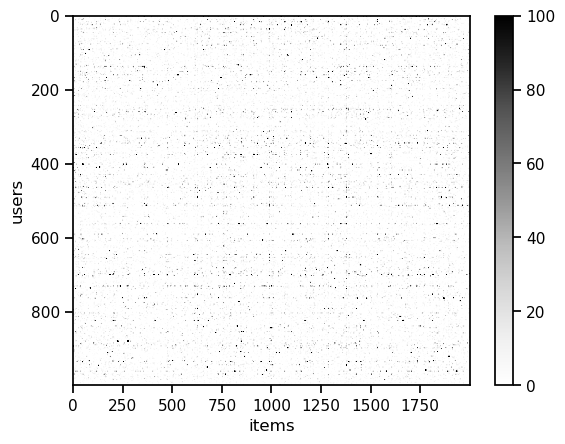

In [16]:
plt.imshow(lfm, aspect="auto", vmax=100, cmap="Greys")
plt.xlabel("items")
plt.ylabel("users")
plt.colorbar()

Using the code below, run coordinate ascent variational inference on this dataset. Our implementation takes around 10-15 minutes to finish, and achieves a rescaled ELBO of around $-2$.

In [17]:
elbos, (q_z, q_theta, q_phi) = cavi(lfm, 
     num_factors=40, 
     num_iters=200, 
     alpha_theta=1.,
     beta_theta=0.5,
     alpha_phi=1.,
     beta_phi=0.5)

  2%|▏         | 3/200 [01:38<1:48:02, 32.91s/it]


KeyboardInterrupt: 

In [ ]:
print(elbos[-1])

### Investigate "genres"

The columns of $\mathbf{H}$ correspond to weights on artists. Intuitively, each of the $K$ columns should put weight on subsets of artists that are often played together. We might think of these columns as reflecting different "genres" of music. The code below the top 10 artists for a few of these columns. 

In [18]:
# Find the 10 most used genres
genre_loading = q_theta.mean.sum(0)
genre_order = torch.argsort(genre_loading, descending=True)

# Print the top 10 artists for each of the top 10 genres
for genre in genre_order[:10]:
    print("genre ", genre)
    artist_idx = torch.argsort(q_phi.mean[:, genre], 
                               descending=True)[:10].numpy()
    subset = lfm_df[lfm_df['ItemID'].isin(artist_idx)]
    print(subset[['ItemID', 'Artist']].drop_duplicates())
    print("")
    

genre  tensor(7)
       ItemID                             Artist
72        693                  simon & garfunkel
79        381        the jimi hendrix experience
682       276              johann sebastian bach
1054      668                       skinny puppy
1870      950                        the bravery
3036      796                  carpathian forest
3128       11                       edvard grieg
3148      257                   butthole surfers
9069      206                       boxcar racer
9365      206                      box car racer
12290     954                            grendel
23346      11                              grieg
31275     276  bach, johann sebastian(1685-1750)

genre  tensor(1)
      ItemID                  Artist
338      781          blonde redhead
475       12               morrissey
762      912         the raveonettes
876      832            mushroomhead
1664       1                 dj food
2317     151               foreigner
2961     834  einstü

### Problem 4a

Inspect the data either using the csv file or the pandas dataframe and choose a user who has listened to artists you recognize. If you are not familiar with any of the artists, use the listener with UserID 349, who mostly listens to hip-hop artists. For the particular user $n$ you choose, find the 10 artists who are predicted to have the most plays by sorting the vector of mean song counts predicted by the model, i.e. the $n^{\text{th}}$ row of $\mathbb{E}_q [\boldsymbol{\Theta} \boldsymbol{\Phi}^\top ]$. Are these artists you would expect the user would enjoy? Are there any artists that the user has not listened to?

*Hint: Use `torch.argsort(..., descending=True)` to return the indices of the largest elements of a vector in descending order.*

In [19]:
###
user_id = 349

# 2. Compute expected play counts
expected_counts = q_theta.mean @ q_phi.mean.T  # shape (num_users, num_artists)

# 3. Get the predicted top 10 artists for the user
user_counts = expected_counts[user_id]  # shape (num_artists,)
top_artist_indices = torch.argsort(user_counts, descending=True)[:10]
top_artists = lfm_df[lfm_df['ItemID'].isin(top_artist_indices.numpy())]
print(top_artists[['ItemID', 'Artist']].drop_duplicates())

##

IndexError: index 349 is out of bounds for dimension 0 with size 100

## Problem 5: Reflections

### Problem 5a

Discuss one advantage and one disadvantage of fitting a posterior using variational inference vs. sampling from the posterior using MCMC.

---

*Your answer here.*

---

### Problem 5b

First, explain why the assumption that $\mathbf{Z}, \boldsymbol{\Phi}$ and $\boldsymbol{\Theta}$ are independent in the posterior will never hold. 

Next, recall that maximizing the ELBO is equivalent to minimizing the KL divergence between the approximate posterior and the true posterior. In general, how will the approximate posterior differ from the true posterior, given that the variational family does not include the true posterior?

---

*Your answer here.*

---

### Problem 5c

Suppose we are using this model to recommend new items to users. Describe one improvement that could be made to the model which you think would lead to better recommendations.

---

*Your answer here.*

---

## Submission Instructions


**Formatting:** check that your code does not exceed 80 characters in line width. If you're working in Colab, you can set _Tools &rarr; Settings &rarr; Editor &rarr; Vertical ruler column_ to 80 to see when you've exceeded the limit. 

Download your notebook in .ipynb format and use the following commands to convert it to PDF:
```
jupyter nbconvert --to pdf hw5_yourname.ipynb
```

**Dependencies:**

- `nbconvert`: If you're using Anaconda for package management, 
```
conda install -c anaconda nbconvert
```

**Upload** your .pdf files to Gradescope. 